# 🩻 EDA — COVID-19 Radiography Dataset

This notebook explores the COVID Radiography dataset:
- Check dataset structure
- Analyze class balance
- Inspect sample images
- Look at image dimensions & pixel intensity distribution
- Create train/val/test split
- Save results for documentation

⚠️ **Disclaimer**: This dataset is for research/demo use only.  
It is **not for clinical use**.


In [4]:
import os, random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")


In [34]:
import os

root = "../COVID-19_Radiography_Dataset/"
print("Contents of root:", os.listdir(root))

for c in ["Normal","Lung_Opacity","Viral Pneumonia","COVID"]:
    path = os.path.join(root, c, "images")
    if os.path.isdir(path):
        print(c, "->", len(os.listdir(path)), "files")
    else:
        print("Missing:", path)


Contents of root: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
Normal -> 10192 files
Lung_Opacity -> 6012 files
Viral Pneumonia -> 1345 files
Missing: ../COVID-19_Radiography_Dataset/COVID\images


In [23]:
root="../COVID-19_Radiography_Dataset/"
classes=["Normal","Lung_Opacity", "Viral Pneumonia", "COVID"]

,count
Normal,10192
Lung_Opacity,6012
Viral Pneumonia,1345
COVID,0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13568\2752004730.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_df.index, y=counts_df['count'], palette="coolwarm")


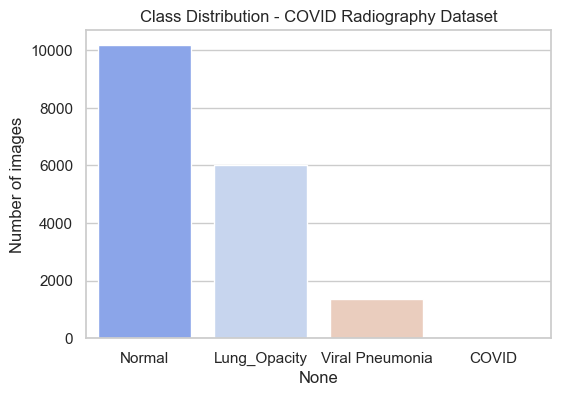

In [35]:

counts = {}
for c in classes:
    class_path = os.path.join(root, c, "images")  # 👈 dive into images/
    if os.path.isdir(class_path):
        counts[c] = len(os.listdir(class_path))
    else:
        print(f"Warning: Folder not found for class '{c}': {class_path}")
        counts[c] = 0

counts_df = pd.DataFrame.from_dict(counts, orient="index", columns=["count"])
display(counts_df)

plt.figure(figsize=(6,4))
sns.barplot(x=counts_df.index, y=counts_df['count'], palette="coolwarm")
plt.title("Class Distribution - COVID Radiography Dataset")
plt.ylabel("Number of images")
plt.show()


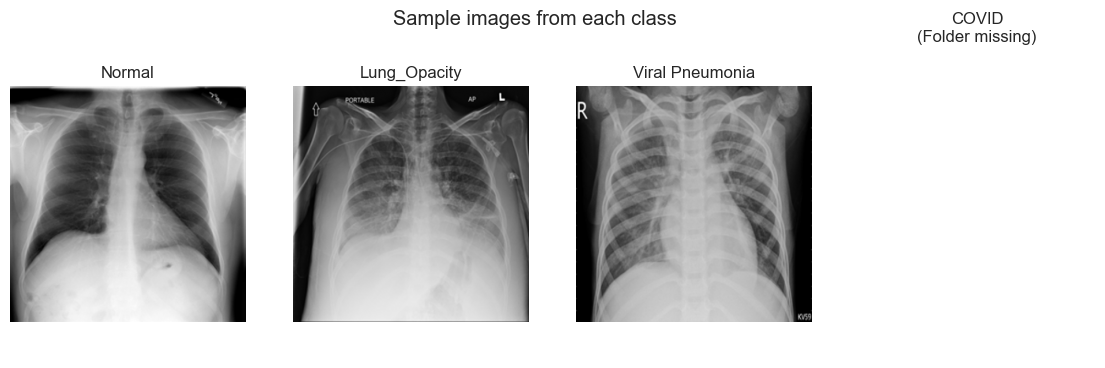

In [28]:
fig, axes = plt.subplots(1, len(classes), figsize=(14,4))
for i, c in enumerate(classes):
    class_dir = os.path.join(root, c, "images")  # 👈 go into images/
    if not os.path.isdir(class_dir):
        axes[i].set_title(f"{c}\n(Folder missing)")
        axes[i].axis("off")
        continue
    # Filter only image files
    files = [f for f in os.listdir(class_dir) 
             if os.path.isfile(os.path.join(class_dir, f)) 
             and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if files:
        sample_file = random.choice(files)
        img = Image.open(os.path.join(class_dir, sample_file))
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(c)
        axes[i].axis("off")
    else:
        axes[i].set_title(f"{c}\n(No images found)")
        axes[i].axis("off")

plt.suptitle("Sample images from each class")
plt.show()


Skipping missing folder: ../COVID-19_Radiography_Dataset/COVID\images
       width  height
count  600.0   600.0
mean   299.0   299.0
std      0.0     0.0
min    299.0   299.0
25%    299.0   299.0
50%    299.0   299.0
75%    299.0   299.0
max    299.0   299.0


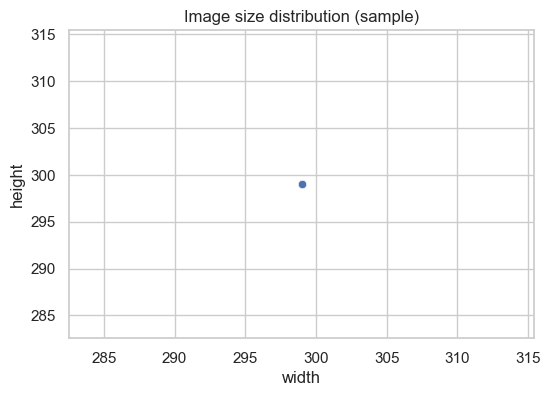

In [36]:
img_sizes = []
for c in classes:
    class_dir = os.path.join(root, c, "images")  # 👈 go into images/
    if not os.path.isdir(class_dir):
        print(f"Skipping missing folder: {class_dir}")
        continue
    # Only select files that are images and not directories
    files = [f for f in os.listdir(class_dir)
             if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))][:200]
    for f in files:
        img = Image.open(os.path.join(class_dir, f))
        img_sizes.append(img.size)

sizes_df = pd.DataFrame(img_sizes, columns=["width","height"])
print(sizes_df.describe())

plt.figure(figsize=(6,4))
sns.scatterplot(x="width", y="height", data=sizes_df)
plt.title("Image size distribution (sample)")
plt.show()


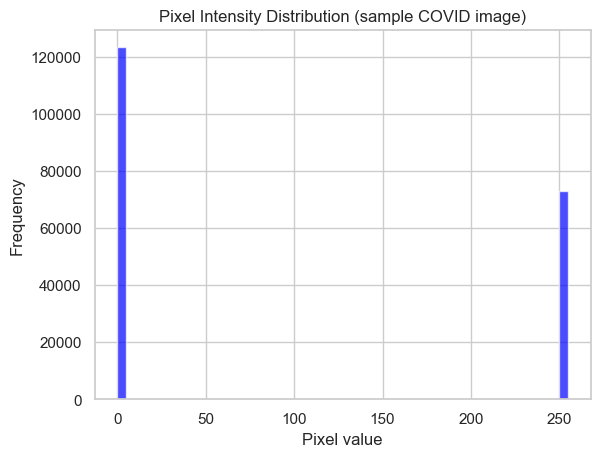

In [37]:
covid_dir = os.path.join(root, "COVID","masks")
# Filter for files only and common image extensions
covid_files = [f for f in os.listdir(covid_dir)
			   if os.path.isfile(os.path.join(covid_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if covid_files:
	sample_img_file = random.choice(covid_files)
	img = Image.open(os.path.join(covid_dir, sample_img_file))
	arr = np.array(img)

	plt.hist(arr.ravel(), bins=50, color="blue", alpha=0.7)
	plt.title("Pixel Intensity Distribution (sample COVID image)")
	plt.xlabel("Pixel value")
	plt.ylabel("Frequency")
	plt.show()
else:
	print("No image files found in COVID directory.")


In [40]:
all_samples = []
for c in classes:
    img_dir = os.path.join(root, c, "images")
    if not os.path.isdir(img_dir):
        print(f"Skipping missing folder: {img_dir}")
        continue
    for f in os.listdir(img_dir):
        all_samples.append({"path": os.path.join(root, c, "images", f), "label": c})

df = pd.DataFrame(all_samples)

min_class_count = df["label"].value_counts().min()
if min_class_count < 2:
    # Not enough samples for stratification
    train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)
    print("⚠️ Not enough samples for stratification. Splitting without stratify.")
else:
    train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df["label"], random_state=42)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
train_df.head()


Skipping missing folder: ../COVID-19_Radiography_Dataset/COVID\images
Train: 12678 Val: 2238 Test: 2633


,path,label
4983,../COVID-19_Radiography_Dataset/Normal\images\...,Normal
4279,../COVID-19_Radiography_Dataset/Normal\images\...,Normal
12687,../COVID-19_Radiography_Dataset/Lung_Opacity\i...,Lung_Opacity
15550,../COVID-19_Radiography_Dataset/Lung_Opacity\i...,Lung_Opacity
984,../COVID-19_Radiography_Dataset/Normal\images\...,Normal


In [44]:
%pip install tabulate

import os

# ensure docs/ exists
os.makedirs("../docs", exist_ok=True)

# save class distribution
counts_df.to_csv("../docs/class_distribution.csv", index=True)

# write data card
with open("../docs/data_card.md", "w", encoding="utf-8") as f:
    f.write("# 🩻 COVID Radiography Dataset — Data Card\n\n")

    f.write("## 📊 Class Distribution\n")
    f.write(counts_df.to_markdown() + "\n\n")

    f.write("## 🔀 Train/Val/Test split\n")
    f.write(f"- Train: {len(train_df)} images\n")
    f.write(f"- Val: {len(val_df)} images\n")
    f.write(f"- Test: {len(test_df)} images\n\n")

    f.write("## ⚠️ Disclaimer\n")
    f.write("This dataset is for **research/demo purposes only**, not for clinical diagnosis.\n")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
